# Transfer learning on graphs

In [2]:
import itertools
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from tools import *

np.random.seed(1)
target, graph = get_data() 

## Get node embedding

In [2]:
%%time
embedding1 = get_embedding(graph, target=target, workers=1, quiet=False)

Generating walks (CPU: 1): 100%|██████████| 10/10 [05:03<00:00, 30.35s/it]


CPU times: user 5min 29s, sys: 9.03 s, total: 5min 38s
Wall time: 5min 36s


Class distribution:

In [5]:
embedding1['target'].value_counts()

IR        532
Agents    463
DB        388
ML        308
HCI       304
AI        115
Name: target, dtype: int64

## Train classifiers

In [5]:
train, test = train_test_split(embeddings, stratify=embeddings['target'])
clf = XGBClassifier()
clf.fit(*split(train))
clf.test(*split(test))
clf.roc_auc_score

0.9028253670250544

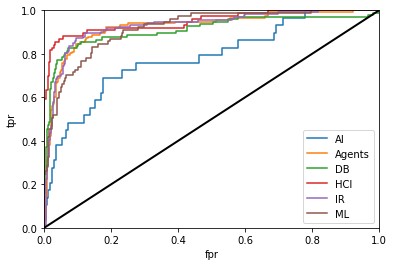

In [6]:
plot_roc_curve(clf)

## TSNE plot

In [2]:
embeddings = pd.read_pickle('temp.pkl').drop(columns='quiet')

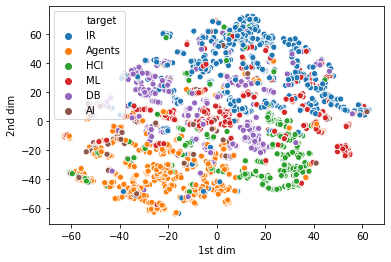

In [3]:
plot_tsne(embeddings1)

## Check determenistic

### Exact same embedding, check classifier
We see that `train_test_split` and `XGBClasssifier` returns same results every run (deterministic).

In [18]:
embedding = get_embedding(graph, target=target, workers=1, quiet=True)
embedding.to_pickle('embedding.pkl')

In [19]:
def func():
    train, test = train_test_split(embedding, stratify=embedding['target'])
    clf = XGBClassifier()
    clf.fit(*split(train))
    clf.test(*split(test))
    return clf

In [21]:
with Pool(processes=10) as pool:
    result = pool.starmap(func, [() for i in range(10)])

In [23]:
[clf.roc_auc_score for clf in result]

[0.8883873309894931,
 0.8883873309894931,
 0.8883873309894931,
 0.8883873309894931,
 0.8883873309894931,
 0.8883873309894931,
 0.8883873309894931,
 0.8883873309894931,
 0.8883873309894931,
 0.8883873309894931]

### Same seed in embedding and classifier
This is not the same for the `Node2Vec` function. I could not make this deterministic. Maybe we should raise an issue on Github.

In [2]:
def func():
    embedding = get_embedding(graph, target=target, quiet=True)
    train, test = train_test_split(embedding, stratify=embedding['target'])
    clf = XGBClassifier(n_jobs=12)
    clf.fit(*split(train))
    clf.test(*split(test))
    return clf

In [3]:
from multiprocessing import Pool
with Pool(processes=10) as pool:
    result = pool.starmap(func, [() for _ in range(10)])

In [7]:
pd.Series([clf.roc_auc_score for clf in result]).agg(['mean', 'std'])

mean    0.908159
std     0.009662
dtype: float64

## Stability

In this section we vary the seed of the embedding **and** the classifier. We see only a limited variance.

In [8]:
def func(random_seed):
    embedding = get_embedding(graph, target=target, quiet=True, seed=random_seed)
    train, test = train_test_split(embedding, stratify=embedding['target'])
    clf = XGBClassifier(random_seed)
    clf.fit(*split(train))
    clf.test(*split(test))
    return clf

In [9]:
with Pool(processes=10) as pool:
    result = pool.starmap(func, [(i,) for i in range(10)])

In [10]:
pd.Series([clf.roc_auc_score for clf in result]).agg(['mean', 'std'])

mean    0.904328
std     0.011094
dtype: float64

## Learn model on different seed than testing

We will learn two node embeddings $\text{emb}_a$ and $\text{emb}_b$ using two different seeds. The model trained on $\text{emb}_a$ does not work on $\text{emb}_b$ for any reasonable value for $p$, $q$, $dimensions$.

In [24]:
def do_experiment(p, q, dimensions):
    random_seed = 1
    embedding1 = get_embedding(graph, dimensions, p=p, q=q, target=target, quiet=True, seed=random_seed)
    train, test = train_test_split(embedding1, stratify=embedding1['target'])
    clf = XGBClassifier(n_jobs=5)
    clf.fit(*split(train))
    clf.test(*split(test))
    same = clf.roc_auc_score
    embedding2 = get_embedding(graph, dimensions, p=p, q=q, target=target, quiet=True, seed=random_seed+1)
    _, test = train_test_split(embedding2, stratify=embedding2['target'])
    clf.test(*split(test))
    diff = clf.roc_auc_score
    return dict(same=same, diff=diff, dimensions=dimensions, p=p, q=q)

In [25]:
it = [(p, q, dim) for p in [1, 2, 4, 8] for q in [1, 2, 4, 8] for dim in [1, 2, 4, 8, 16, 32, 64]]

In [26]:
with Pool(processes=len(it)) as pool:
    result = pool.starmap(do_experiment, it)

In [27]:
with pd.option_context("display.max_rows", 200):
    display(pd.DataFrame(result).sort_values('diff'))

,same,diff,dimensions,p,q
85,0.719881,0.379817,2,8,1
47,0.892277,0.407715,32,2,4
12,0.892955,0.412077,32,1,2
92,0.737319,0.419124,2,8,2
5,0.871876,0.422655,32,1,1
29,0.713553,0.422966,2,2,1
67,0.873588,0.429787,16,4,2
8,0.671761,0.430134,2,1,2
111,0.913995,0.433608,64,8,8
89,0.900216,0.435775,32,8,1


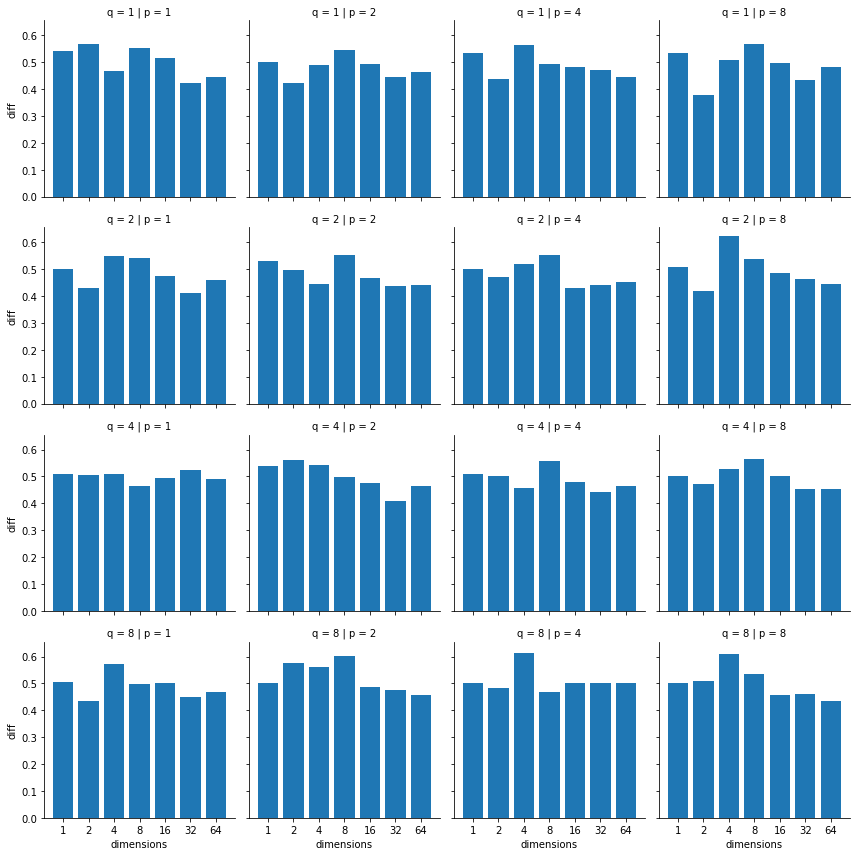

In [28]:
g = sns.FacetGrid(result.astype({'dimensions': str}), col="p", row="q")
g.map(plt.bar, 'dimensions', 'diff')

In [33]:
result.groupby('dimensions')['diff'].agg(['mean', 'var'])

,mean,var
dimensions,,
1,0.513388,0.000285
2,0.479485,0.003293
4,0.535053,0.002995
8,0.533118,0.001466
16,0.483758,0.000425
32,0.452515,0.000910
64,0.460529,0.000349


In [34]:
result.groupby(['p', 'q'])['diff'].agg(['mean', 'var'])

mean       var
p q                    
1 1  0.502489  0.003277
  2  0.481670  0.002811
  4  0.498664  0.000321
  8  0.490385  0.002018
2 1  0.480063  0.001631
  2  0.483006  0.002121
  4  0.497352  0.002901
  8  0.522422  0.003131
4 1  0.489455  0.002063
  2  0.480813  0.002070
  4  0.486893  0.001498
  8  0.509648  0.002229
8 1  0.486702  0.003891
  2  0.497319  0.004723
  4  0.496091  0.001736
  8  0.500675  0.003551